In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import tifffile as tiff 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
REBUILD_DATA = False
IMG_SIZE = 50
class FireDetector():
    FIRE = "./Fire"
    NOFIRE = "./NoFire"
    LABELS = {NOFIRE:0, FIRE:1}
    training_data = []
    fire_count = 0
    nofire_count = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = tiff.imread(path)
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    img = np.array(img)
                    img = np.uint8(img)
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])

                    #check that dataset is balanced
                    if label == self.FIRE:
                        self.fire_count +=1
                    if label == self.NOFIRE:
                        self.nofire_count +=1
                except Exception as e:
                    print(str(e))
                    pass
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Fire: ", self.fire_count)
        print("NoFire: ", self.nofire_count)
if REBUILD_DATA:
    firedetector = FireDetector()
    firedetector.make_training_data()

In [3]:
training_data = np.load("training_data.npy", allow_pickle = True)

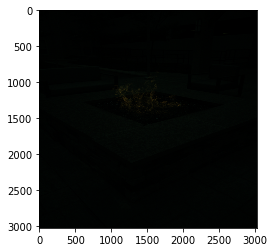

In [11]:
plt.imshow(training_data[13][0]/256**2)
plt.show()

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) #1 input, outputs 32 conv features, 5x5 kernel
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        #flatten...TODO: look up torch.flatten examples for better way to do this
        x = torch.randn(IMG_SIZE, IMG_SIZE).view(-1, 1, IMG_SIZE, IMG_SIZE)
        self._to_linear = None
        self.convs(x)
        self.fc1 = nn.Linear(self._to_linear, 512) #linear layer = dense layer = fully connected layer
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim = 1)
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [5]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,IMG_SIZE,IMG_SIZE)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

6


In [6]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]
print(len(train_X), len(test_X))

60 6


In [8]:
BATCH_SIZE = 1
EPOCHS = 10

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")

 22%|█████████████████▊                                                                | 13/60 [00:00<00:00, 61.33it/s]C:\Users\kaitl\anaconda3\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([0, 2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 10%|████████▎                                                                          | 6/60 [00:00<00:00, 57.85it/s]

Epoch: 0. Loss: nan


 12%|█████████▋                                                                         | 7/60 [00:00<00:00, 64.39it/s]

Epoch: 1. Loss: nan


 12%|█████████▋                                                                         | 7/60 [00:00<00:00, 65.60it/s]

Epoch: 2. Loss: nan


 12%|█████████▋                                                                         | 7/60 [00:00<00:00, 60.51it/s]

Epoch: 3. Loss: nan


 10%|████████▎                                                                          | 6/60 [00:00<00:01, 53.24it/s]

Epoch: 4. Loss: nan


 12%|█████████▋                                                                         | 7/60 [00:00<00:00, 62.11it/s]

Epoch: 5. Loss: nan


 12%|█████████▋                                                                         | 7/60 [00:00<00:00, 61.03it/s]

Epoch: 6. Loss: nan


 12%|█████████▋                                                                         | 7/60 [00:00<00:00, 62.11it/s]

Epoch: 7. Loss: nan


 12%|█████████▋                                                                         | 7/60 [00:00<00:00, 62.11it/s]

Epoch: 8. Loss: nan


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 61.58it/s]

Epoch: 9. Loss: nan


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, IMG_SIZE, IMG_SIZE))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))